**Authored by [Will Connell](https://twitter.com/wilstc)**

**Published 04/23/2020**

**[Keiser Laboratory](https://www.keiserlab.org/), UCSF**

**Find the Pytorch Metric Learning library [documentation](https://kevinmusgrave.github.io/pytorch-metric-learning/) & [GitHub](https://github.com/KevinMusgrave/pytorch-metric-learning/)**

## Install the necessary packages

In [1]:
!pip install -q pytorch-metric-learning[with-hooks]
!pip install -q scanpy

     |████████████████████████████████| 102 kB 6.2 MB/s 
     |████████████████████████████████| 89.7 MB 15 kB/s 
     |████████████████████████████████| 2.0 MB 4.5 MB/s 
     |████████████████████████████████| 91 kB 8.4 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 46.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


## Import the packages

In [2]:
%matplotlib inline
import logging

# Viz
import matplotlib.pyplot as plt
import numpy as np

# Data manipulation
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets

# Main
from pytorch_metric_learning import losses, miners, samplers, testers, trainers

sns.set(rc={"figure.figsize": (8.7, 6.27)})
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

# Logs
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 1.0.0


## Models and Datasets

In [3]:
class EmbeddingNet(nn.Module):
    # Useful code from fast.ai tabular model
    # https://github.com/fastai/fastai/blob/3b7c453cfa3845c6ffc496dd4043c07f3919270e/fastai/tabular/models.py#L6
    def __init__(self, in_sz, out_sz, emb_szs, ps, use_bn=True, actn=nn.ReLU()):
        super(EmbeddingNet, self).__init__()
        self.in_sz = in_sz
        self.out_sz = out_sz
        self.n_embs = len(emb_szs) - 1
        if ps == 0:
            ps = np.zeros(self.n_embs)
        # input layer
        layers = [nn.Linear(self.in_sz, emb_szs[0]), actn]
        # hidden layers
        for i in range(self.n_embs):
            layers += self.bn_drop_lin(
                n_in=emb_szs[i], n_out=emb_szs[i + 1], bn=use_bn, p=ps[i], actn=actn
            )
        # output layer
        layers.append(nn.Linear(emb_szs[-1], self.out_sz))
        self.fc = nn.Sequential(*layers)

    def bn_drop_lin(
        self,
        n_in: int,
        n_out: int,
        bn: bool = True,
        p: float = 0.0,
        actn: nn.Module = None,
    ):
        # https://github.com/fastai/fastai/blob/3b7c453cfa3845c6ffc496dd4043c07f3919270e/fastai/layers.py#L44
        "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
        layers = [nn.BatchNorm1d(n_in)] if bn else []
        if p != 0:
            layers.append(nn.Dropout(p))
        layers.append(nn.Linear(n_in, n_out))
        if actn is not None:
            layers.append(actn)
        return layers

    def forward(self, x):
        output = self.fc(x)
        return output


# This will be used to create train and val sets
class BasicDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = labels

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

## Create the dataset and train/val splits

In [4]:
# get data and format
adata = sc.datasets.paul15()
# can try preprocessing here...
# sc.pp.recipe_zheng17(adata)

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


This dataset is from a 2015 *Cell* paper titled: ["Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors"](https://www.cell.com/cell/fulltext/S0092-8674(15)01493-2?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867415014932%3Fshowall%3Dtrue).

We will use cell type clusters that the authors were able to define through canonical marker genes to train and validate embeddings. Then, we will project remaining clusters into the metric space. From the publication:



> "We found that, while some of the single-cell clusters (e.g. C1–C6, C14–C15, C16–C17) 
form groups that express marker genes corresponding to erythrocyte, monocyte, and neutrophil progenitors, 
other clusters (C7–C13) showed specific and distinct progenitor expression distributions that were not 
aligned with a simple hierarchical model of the population"



In [5]:
# create dictionary of label map
label_map = dict(enumerate(adata.obs["paul15_clusters"].cat.categories))
label_map

{0: '1Ery',
 1: '2Ery',
 2: '3Ery',
 3: '4Ery',
 4: '5Ery',
 5: '6Ery',
 6: '7MEP',
 7: '8Mk',
 8: '9GMP',
 9: '10GMP',
 10: '11DC',
 11: '12Baso',
 12: '13Baso',
 13: '14Mo',
 14: '15Mo',
 15: '16Neu',
 16: '17Neu',
 17: '18Eos',
 18: '19Lymph'}

In [6]:
# extract of some of the most representative clusters for training/testing
clusters = [0, 1, 2, 3, 4, 5, 13, 14, 15, 16]
indices = adata.obs["paul15_clusters"].cat.codes.isin(clusters)
data, labels = adata.X[indices], adata.obs[indices]["paul15_clusters"].cat.codes.values

# extract holdout clusters for projection
hld_data, hld_labels = (
    adata.X[~indices],
    adata.obs[~indices]["paul15_clusters"].cat.codes.values,
)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, stratify=labels, test_size=0.2, random_state=77
)

## Initialize datasets, models, and optimizers

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training, validation, holdout set
train_dataset = BasicDataset(X_train, y_train)
val_dataset = BasicDataset(X_val, y_val)
hld_dataset = BasicDataset(hld_data, hld_labels)

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
model = EmbeddingNet(
    in_sz=len(adata.var),
    out_sz=25,
    emb_szs=[1000, 500, 250, 100],
    ps=0,
    use_bn=False,
    actn=nn.ReLU(),
)
model = nn.DataParallel(model).to(device)

# Set optimizers
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)

##Create the loss, miner, sampler, and package them into dictionaries


In [9]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    y_train.flatten(), m=4, length_before_new_iter=len(train_dataset)
)

# Set other training parameters
batch_size = 64
num_epochs = 10

# Package the above stuff into dictionaries.
models = {"trunk": model}
optimizers = {"trunk_optimizer": model_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

## Create the training and testing hooks

In [10]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs/ example_saved_models/ example_tensorboard/

In [11]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"train": train_dataset, "val": val_dataset}
model_folder = "example_saved_models"

# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    dataloader_num_workers=2,
    use_trunk_output=True,
)

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, dataset_dict, model_folder, test_interval=1, patience=5
)

## Create the trainer

In [12]:
trainer = trainers.MetricLossOnly(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    mining_funcs,
    train_dataset,
    sampler=sampler,
    dataloader_num_workers=2,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

## Train the model

In [13]:
trainer.train(num_epochs=num_epochs)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=0.10871: 100%|██████████| 22/22 [00:05<00:00,  4.25it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|██████████| 12/12 [00:00<00:00, 62.95it/s]
INFO:PML:Getting embeddings for the train split
100%|██████████| 46/46 [00:00<00:00, 137.88it/s]
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=1472
INFO:PML:embedding dimensionality is 25
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 25
INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=368
INFO:PML:embedding dimensionality is 25
INFO:PML:running k-means clustering with k=10
INFO:PML:embedding dimensionality is 25
INFO:PML:New best accuracy! 0.23065649395024215
INFO:PML:TRAINING EPOCH 2
total_loss=0.09025: 100%|██████████| 22/22 [00:00<00

## Evaluate Loss and Accuracies

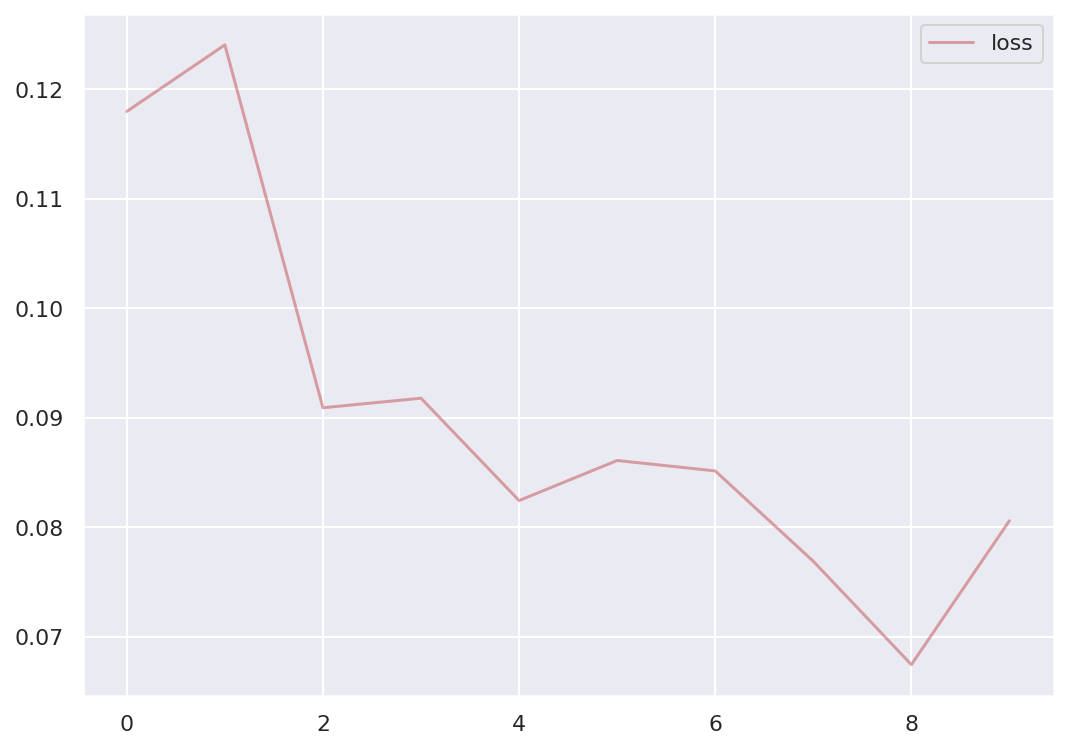

In [14]:
loss_history = hooks.get_loss_history()
plt.plot(loss_history["metric_loss"], "r", alpha=0.5, label="loss")
plt.legend()

Text(0.5, 1.0, 'Adjusted Mutual Info')

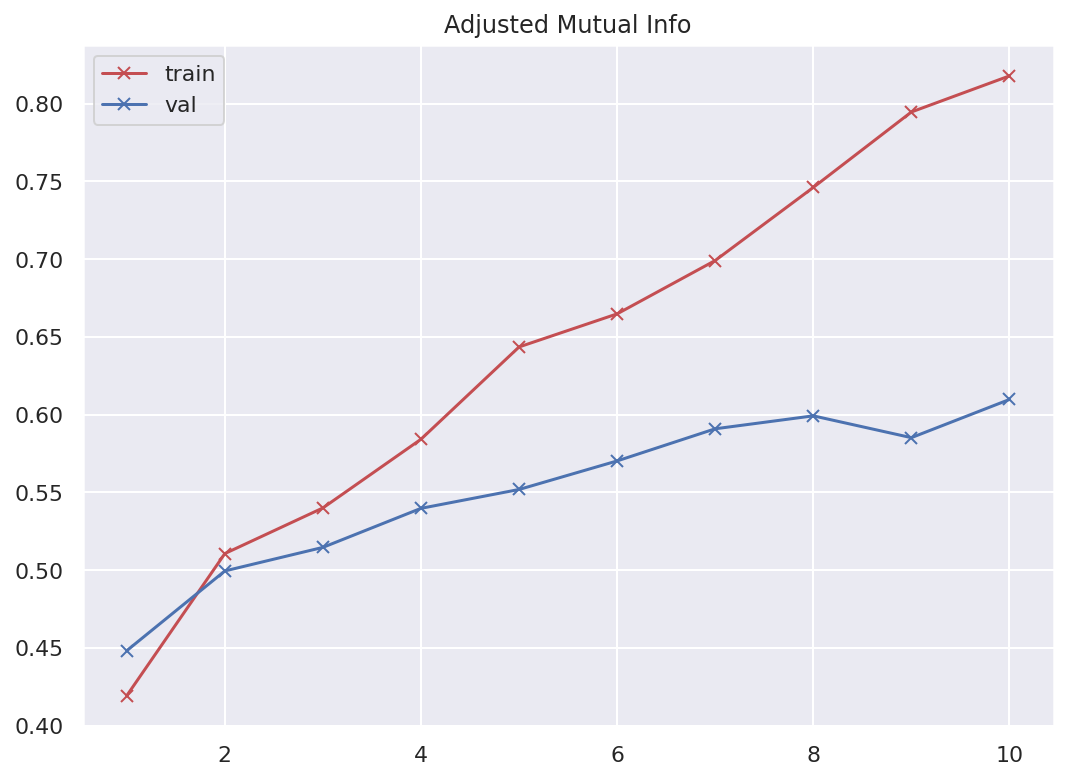

In [15]:
for c, ds in zip(["r", "b"], ["train", "val"]):
    accuracies = hooks.get_accuracy_history(tester, ds, return_all_metrics=True)
    plt.plot(accuracies["epoch"], accuracies["AMI_level0"], "{}x-".format(c), label=ds)
plt.legend()
plt.title("Adjusted Mutual Info")

## Visualize Embeddings

In [16]:
# extract embeddings
train_emb, train_lab = tester.get_all_embeddings(
    train_dataset, model, return_as_numpy=True
)
val_emb, val_lab = tester.get_all_embeddings(val_dataset, model, return_as_numpy=True)
hld_emb, hld_lab = tester.get_all_embeddings(hld_dataset, model, return_as_numpy=True)

100%|██████████| 28/28 [00:00<00:00, 107.01it/s]


In [17]:
# Visualize embeddings using tSNE
# combine validation and holdout embeddings
comb_emb = np.concatenate((train_emb, val_emb))
comb_lab = np.concatenate((train_dataset.labels, val_dataset.labels))
comb_src = np.concatenate(
    (np.repeat("TRAIN", len(train_emb)), np.repeat("VAL", len(val_emb)))
)

comb_tsne = TSNE().fit_transform(comb_emb)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


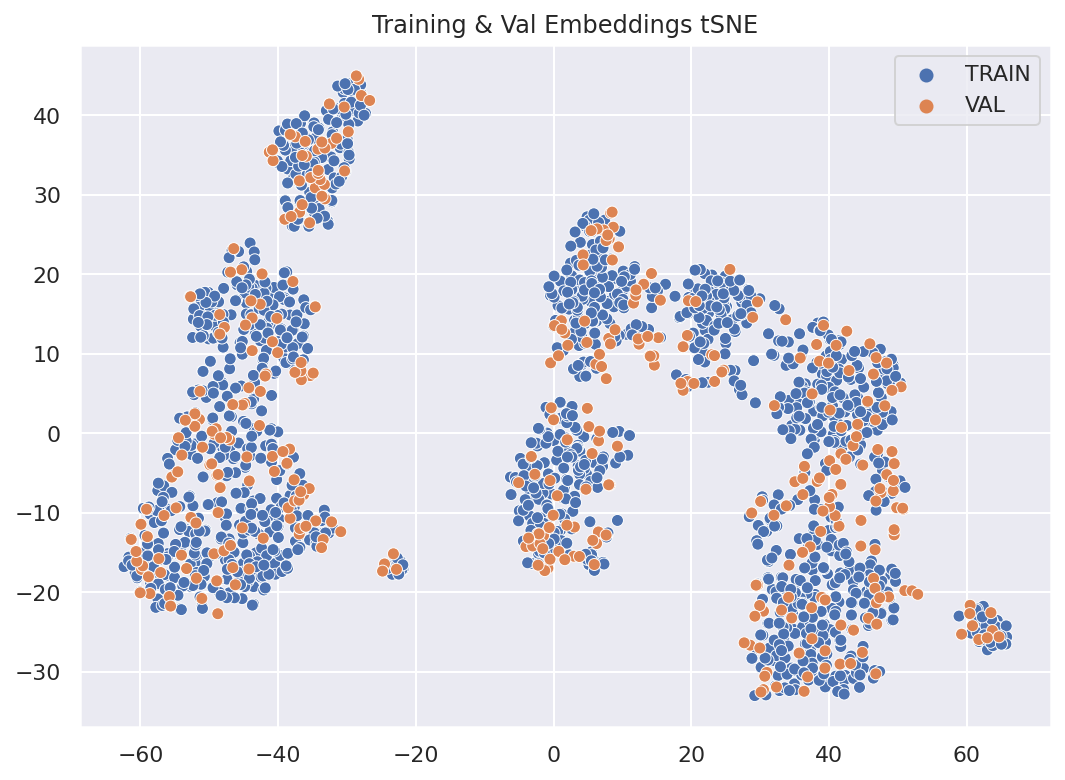

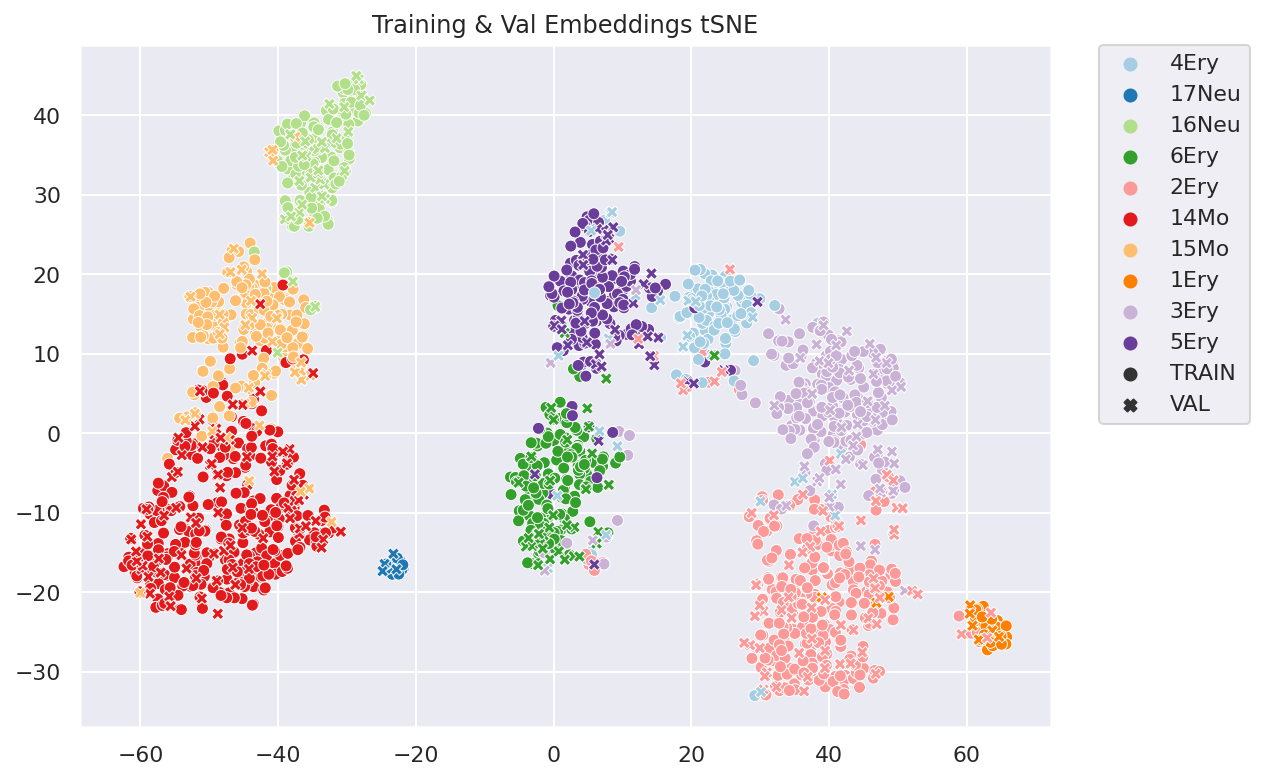

In [18]:
sns.scatterplot(x=comb_tsne[:, 0], y=comb_tsne[:, 1], hue=comb_src)
plt.title("Training & Val Embeddings tSNE")
plt.show()
sns.scatterplot(
    x=comb_tsne[:, 0],
    y=comb_tsne[:, 1],
    hue=[label_map[i] for i in comb_lab],
    style=comb_src,
    palette="Paired",
)
plt.title("Training & Val Embeddings tSNE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

## Project Holdout Samples

In [19]:
# combine validation and holdout embeddings
comb_hld_emb = np.concatenate((comb_emb, hld_emb))
comb_hld_lab = np.concatenate((comb_lab, hld_labels))
comb_hld_src = np.concatenate((comb_src, np.repeat("HLD", len(hld_emb))))

comb_hld_tsne = TSNE().fit_transform(comb_hld_emb)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


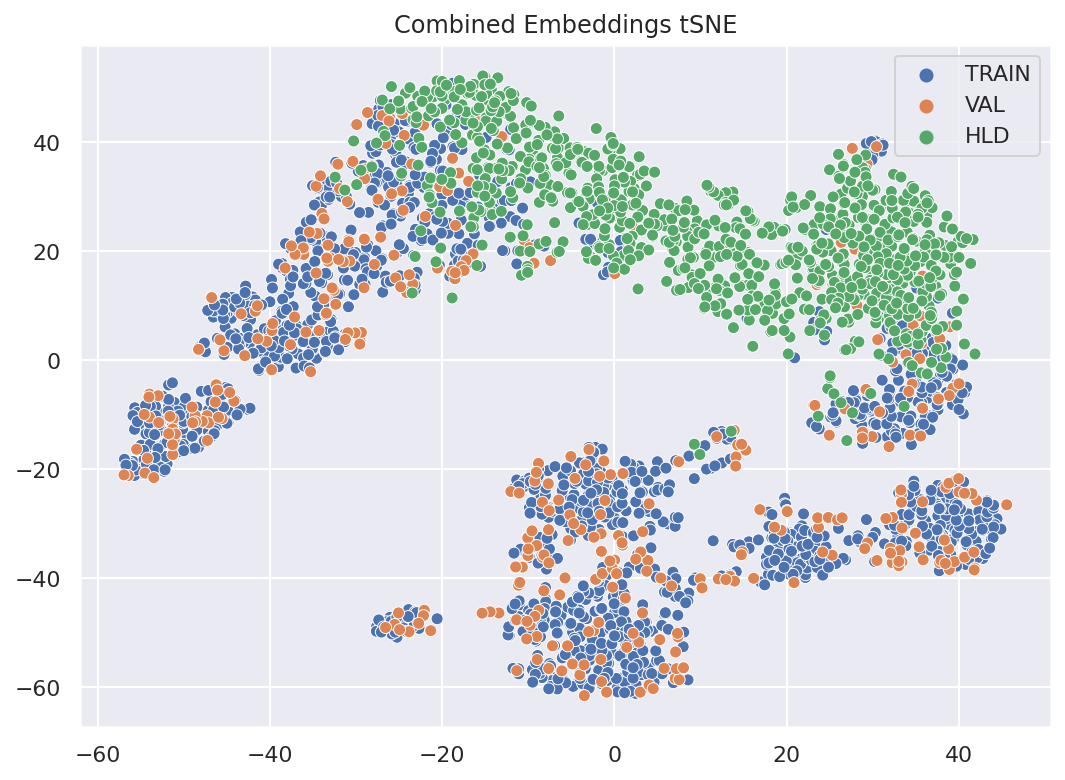

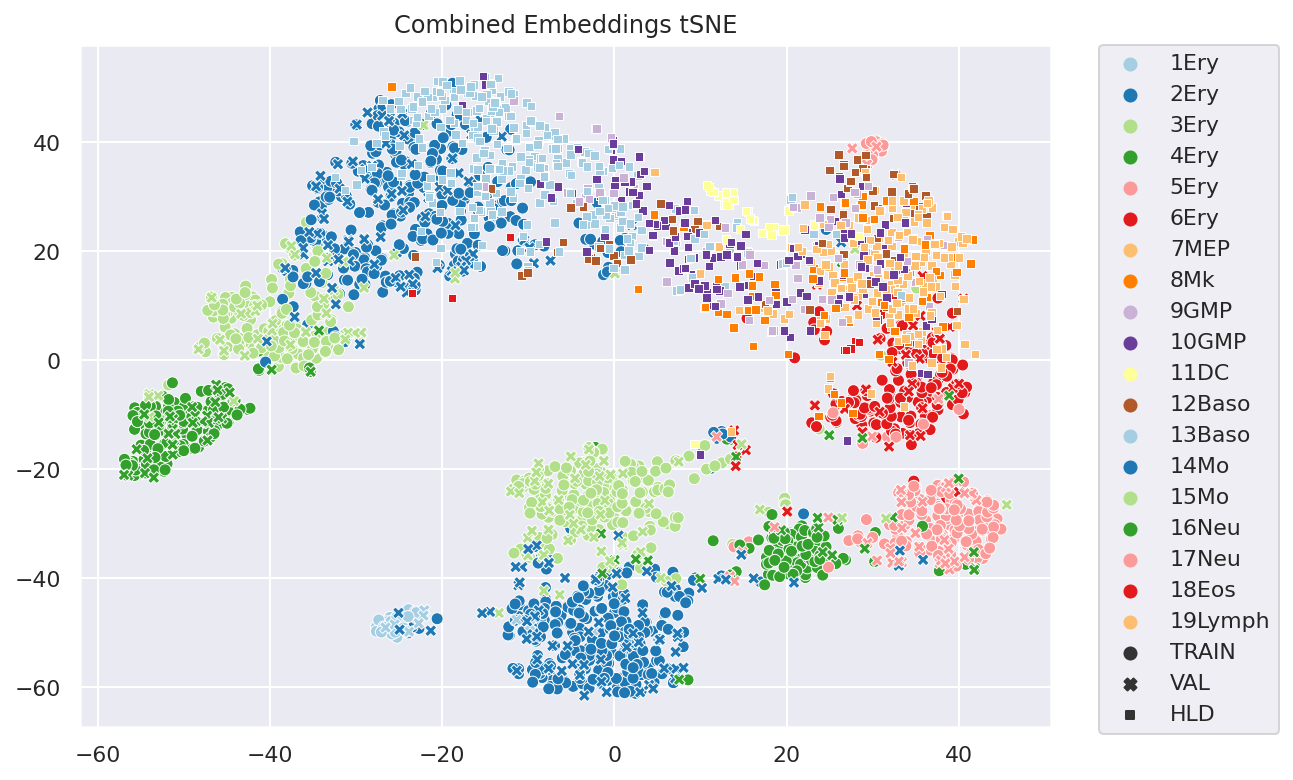

In [20]:
sns.scatterplot(x=comb_hld_tsne[:, 0], y=comb_hld_tsne[:, 1], hue=comb_hld_src)
plt.title("Combined Embeddings tSNE")
plt.show()
sns.scatterplot(
    x=comb_hld_tsne[:, 0],
    y=comb_hld_tsne[:, 1],
    hue=[label_map[i] for i in comb_hld_lab],
    hue_order=label_map.values(),
    style=comb_hld_src,
    palette="Paired",
)
plt.title("Combined Embeddings tSNE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

## Score Cells in Embedding Space

In [21]:
# avergage embedding (prototypical) location of training clusters
comb_df = pd.DataFrame(comb_emb, comb_lab)
proto = comb_df.groupby(comb_df.index).mean()

In [22]:
# distances of holdout embeddings to cluster centers
sim = pairwise_distances(hld_emb, proto.values)
sim_df = pd.DataFrame(
    sim, [label_map[i] for i in hld_labels], [label_map[i] for i in proto.index]
)

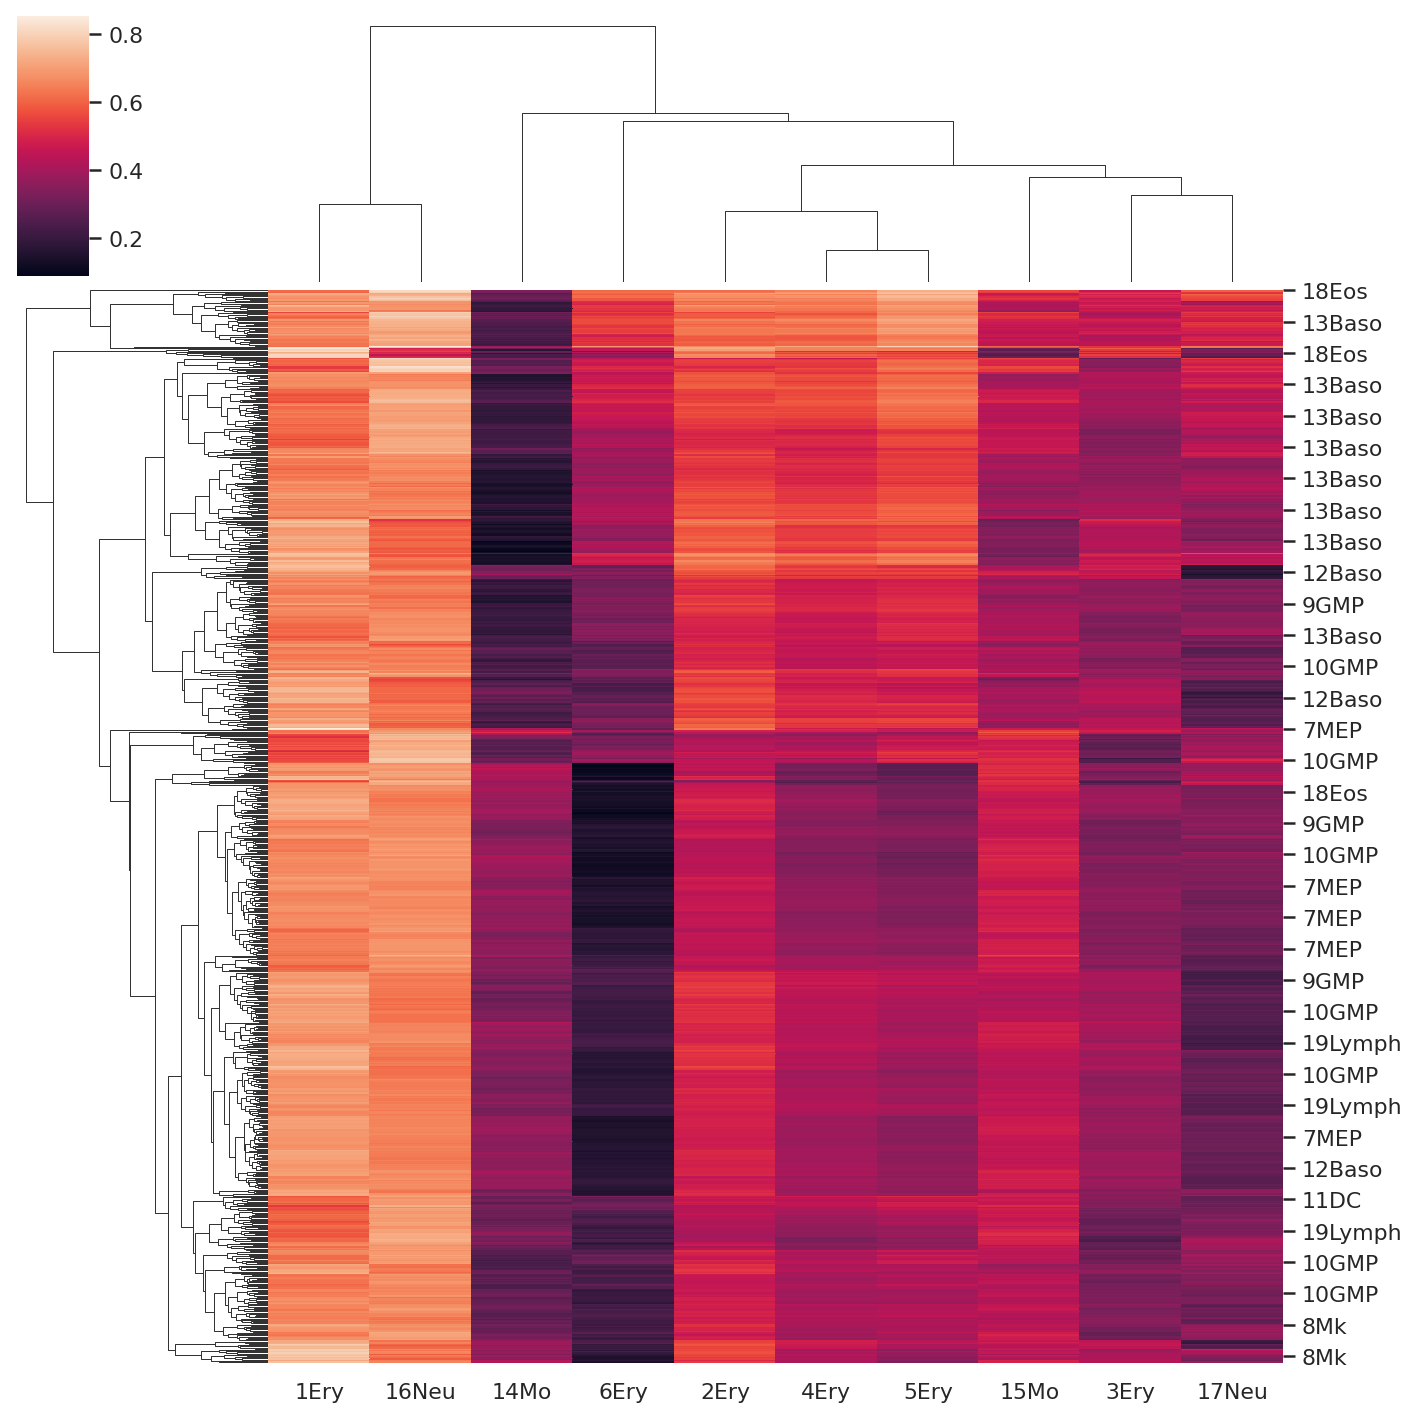

In [23]:
# hierarchical clustering of relative location
sns.clustermap(sim_df)